In [71]:
import jax
import flax
import networkx as nx
import jax.numpy as jnp

In [72]:
@flax.struct.dataclass
class GraphState:
    nodes: jnp.array
    senders: jnp.array
    receivers: jnp.array
    edges: jnp.array

    def unpack(self):
        return self.nodes, self.senders, self.receivers, self.edges

In [73]:
def plot_network(graph_state: GraphState) -> None:
    def convert_state_to_networkx_graph(graph_state) -> nx.Graph:
        nodes, senders, receivers, edges = graph_state.unpack()
        n_nodes = len(nodes)
        n_edges = len(edges)
        nx_graph = nx.DiGraph()

        if nodes is None:
            for n in range(n_nodes):
                nx_graph.add_node(n)
        else:
            for n in range(n_nodes):
                nx_graph.add_node(n, node_feature=nodes[n])
        if edges is None:
            for e in range(n_edges):
                nx_graph.add_edge(int(senders[e]), int(receivers[e]))
        else:
            for e in range(n_edges):
                nx_graph.add_edge(
                    int(senders[e]), int(receivers[e]), edge_feature=edges[e]
                )
        return nx_graph

    nx_graph = convert_state_to_networkx_graph(graph_state)
    pos = nx.spring_layout(nx_graph)
    nx.draw(nx_graph, pos=pos, with_labels=True, node_size=500, font_color="yellow")

In [74]:
n_nodes = 7
nodes = jnp.zeros(n_nodes)
senders = jnp.array([0, 1, 1, 2, 3, 4, 6])
receivers = jnp.array([3, 3, 4, 6, 5, 5, 5])
edges = jnp.ones(len(senders))

In [75]:
activation_mask = jnp.array([1, 1, 1, 0, 0, 0, 0])
output_mask = jnp.array([0, 0, 0, 0, 1, 0, 0])
activations = jnp.zeros(len(nodes))

In [76]:
inputs = jnp.array([1, 1, 1])
n_inputs = len(inputs)
activations = activations.at[:n_inputs].set(inputs)
activations


Array([1., 1., 1., 0., 0., 0., 0.], dtype=float32)

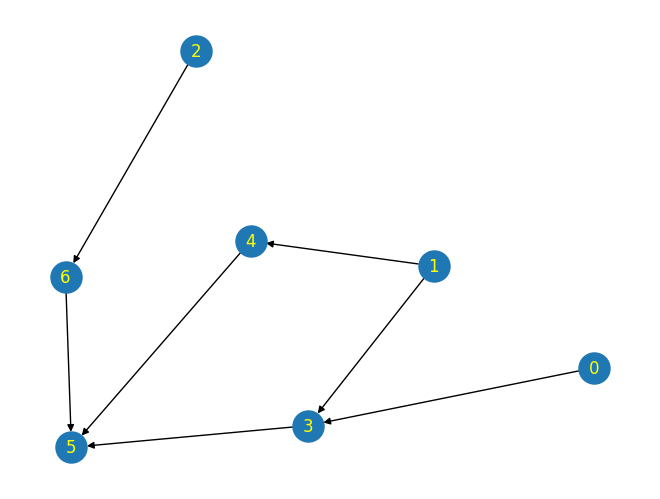

In [98]:
graph_state = GraphState(nodes, senders, receivers, edges)
plot_network(graph_state)

### ***Pseudo-code: Forward Pass***

```python
while output not received all activations:
    # iterate through neurons activated at step n
    for activated neurons:
        # transmit activation to receiver neuron
        nodes[receiver] += nodes[activated]
    # compute the activation function when a neuron
    # has received all activations from its input neurons
    if receiver received all activations:
        nodes[receiver] = activation(nodes[receiver])
    # update activation mask for next iteration
    activation_mask = zeros.at[receivers].set(1)
```

In [80]:
def update_activations(sender, receiver, nodes):
    return nodes.at[receiver].add(nodes[sender])

activations

Array([1., 1., 1., 0., 0., 0., 0.], dtype=float32)

In [86]:
receivers.at[jnp.nonzero(receivers * activation_mask)].get()

Array([3, 3, 4], dtype=int32)

In [91]:
senders

Array([0, 1, 1, 2, 3, 4, 6], dtype=int32)

In [92]:
receivers

Array([3, 3, 4, 6, 5, 5, 5], dtype=int32)

In [89]:
jnp.nonzero(senders * activation_mask, )

(Array([1, 2], dtype=int32),)

In [ ]:
jax.lax.scan(update_activations, (nodes), (senders, receivers))

In [79]:
# for activated in jnp.where(activation_mask == 1)[0]:
#     receiver = receivers[activated]
#     print(receiver, activations[activated])
#     nodes = nodes.at[receiver].add(activations[activated])

# nodes